In [1]:
%matplotlib inline

In [95]:
#import cv2
from scipy.misc import imread
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
import re
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.io import imsave
import random
#from skimage.transform import rotate
from scipy.ndimage.interpolation import rotate

In [97]:
def convertX(p, metersPerPixel):
    return p*metersPerPixel*10000+680

def convertY(p, metersPerPixel):
    return p*metersPerPixel*10000+512

def getCoordsFromPoint(el):
        x = None
        y = None
        for e in el:
            if e.tag == "PointIndex" and e.text == '2':
                return None
            if e.tag == "PositionX":
                x = e.text
            if e.tag == "PositionY":
                y = e.text

        return [x,y]

    
def getPointsFromLMD(filename):
    tree = ET.parse(filename)
    points = []
    for c in tree.getroot():
        for c2 in c:
            if c2.tag == "LMMeasurementItemPoints":
                coords = getCoordsFromPoint(c2)
                if coords:
                    points.append([float(i) for i in coords])
                    
    return points

def getCalibration(filename):
    with open(filename, 'r') as f:
        metersPerPixel = float(re.match(r'.*<MetresPerPixel>(.*)</MetresPerPixel>.*', f.read(), flags=re.DOTALL).groups()[0])
    return metersPerPixel

# https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation/26386665
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def randomSample(im, x_extent, y_extent):
    x = x_extent[0]
    w = x_extent[1] - x_extent[0]
    y = y_extent[0]
    h = y_extent[1] - y_extent[0]
    
    while get_iou(
            {'x1': x_extent[0], 'x2': x_extent[1], 'y1': y_extent[0], 'y2': y_extent[1]},
            {'x1': x, 'x2': x+w, 'y1': y, 'y2': y+h}
        ) > 0:
    
        w = random.randint(50,300)
        h = random.randint(50,300)

        x = random.randint(0, im.shape[1] - w)
        y = random.randint(0, im.shape[0] - h)

    return im[y:y+l,x:x+w]

for p in Path('samples').glob('**/*.tif'):
    print(p)
    
    points = getPointsFromLMD(str(p) + '.lmd')
    if len(points) != 4:
        continue
    metersPerPixel = getCalibration(str(p) + '.anx')
    buffer = 50
    x_extent = int(convertX(np.array(points)[:,0].min(), metersPerPixel)-buffer), int(convertX(np.array(points)[:,0].max(), metersPerPixel)+buffer)
    y_extent = int(convertY(np.array(points)[:,1].min(), metersPerPixel)-buffer), int(convertY(np.array(points)[:,1].max(), metersPerPixel)+buffer)

    im = imread(str(p))
    
    '''ax = plt.imshow(im)
    
    for i in range(0,len(points), 4):

        for x,y in points[i+0:i+2]:
            plt.scatter(convertX(x, metersPerPixel), convertY(y, metersPerPixel), c='red')

        for x,y in points[i+2:i+4]:
            plt.scatter(convertX(x, metersPerPixel), convertY(y, metersPerPixel), c='orange')
            
    ax.axes.set_xlim(x_extent)
    ax.axes.set_ylim(y_extent[1], y_extent[0])
    plt.show()'''
    
    cropped = im[y_extent[0]:y_extent[1], x_extent[0]:x_extent[1]]
    for i in [0, 90, 180, 270]:
        
        imsave('cropped/%s_%s' % (i, str(p).replace('\\', '_').replace('/', '_')), rotate(cropped, i))
    
    for i in range(10):
        s = randomSample(im, x_extent, y_extent)
        imsave('negative_samples/%s.tif' % random.randint(0,100000000), s)
    #plt.imshow(cropped); plt.show()
    
        
    

samples\Anthopleuramariscali_MEX20@\filament\image0011.tif
samples\Anthopleuramariscali_MEX20@\filament\image0023.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/98639498.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/56047636.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/69526769.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/84908690.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/69874753.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/65281723

samples\Anthopleuramariscali_MEX20@\filament\image0033.tif
samples\Anthopleuramariscali_MEX20@\filament\image0052.tif
samples\Anthopleuramariscali_MEX20@\filament\image0065.tif
samples\Anthopleuramariscali_MEX20@\filament\image0074.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/85210780.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/68731509.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/34759312.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/52140750.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/37409112.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


samples\Anthopleuramariscali_MEX20@\filament\image0075.tif
samples\Anthopleuramariscali_MEX20@\filament\image0077.tif
samples\Anthopleuramariscali_MEX20@\filament\image0079.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/75151595.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/65656259.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/56468120.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/4676931.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/78759514.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/24164399.

samples\Anthopleuramariscali_MEX20@\filament\image0080.tif
samples\AnthopleuraMEX1@\filament\image.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/8675573.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/84735140.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/33150163.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/2231676.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/9083535.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/4576766.tif

samples\AnthopleuraMEX1@\filament\image0014.tif
samples\AnthopleuraMEX1@\filament\image0028.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/41073259.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/31567148.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/92881154.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/61097795.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/186047.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/31171199.t

samples\AnthopleuraMEX1@\filament\image0041.tif
samples\AnthopleuraMEX1@\filament\image0048.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/8999365.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/64950356.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/52098038.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/3534751.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/18106839.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/99735727.t

samples\AnthopleuraMEX1@\filament\image0064.tif
samples\AnthopleuraMEX3@\filament\image0010.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/71855489.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/14718066.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/36072836.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/73476405.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/87271244.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/57536213

samples\AnthopleuraMEX3@\filament\image0012.tif
samples\AnthopleuraMEX3@\filament\image0013.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/43479765.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/81114562.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/6140106.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/18041982.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/27037183.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/93321186.

samples\AnthopleuraMEX3@\filament\image0018.tif
samples\AnthopleuraMEX3@\filament\image0022.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/89544433.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/83050007.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/9421848.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/54445952.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/33344827.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/19980860.

samples\AnthopleuraMEX3@\filament\image0026.tif
samples\AnthopleuraMEX3@\filament\image0031.tif
samples\AnthopleuraPAN49\filament\image.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/19182135.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/84303056.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/98053447.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/7580971.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/9547503.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/52779974.t

samples\AnthopleuraPAN49\filament\image0001.tif
samples\AnthopleuraPAN49\filament\image0003.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/60397948.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/39896460.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/49115280.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/78417491.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/78866633.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/54887512

samples\AnthopleuraPAN49\filament\image0004.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/26458638.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/24191875.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/5122278.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/68321692.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/54524216.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/21803862.

samples\AnthopleuraPAN49\filament\image0005.tif
samples\AnthopleuraPAN49\filament\image0010.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/93002303.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/30938667.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/12208484.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/86153854.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/9312843.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/19279619.

samples\AnthopleuraPAN49\filament\image0015.tif
samples\AnthopleuraPAN49\filament\image0016.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/99554131.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/38556423.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/30821561.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/34607620.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/3927354.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/22512251.

samples\AnthopleuraPAN49\filament\image0017.tif
samples\AnthopleuraPAN49\filament\image0023.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/27359693.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/10237405.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/5826201.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/82797172.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/53949105.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/31646542.

samples\AnthopleuraPAN49\filament\image0024.tif
samples\AnthopleuraPAN49\filament\image0025.tif
samples\AnthopleuraPAN49\filament\image0031.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/2214448.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/86307412.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/3387510.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/52168422.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/57525916.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/53736426.t

samples\AnthopleuraPAN49\filament\image0037.tif
samples\AnthopleuraPAN49\filament\image0040.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/53073296.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/66329460.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/66414710.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/23369712.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/72799663.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/16924602

samples\AnthopleuraPAN49\filament\image0042.tif
samples\AnthopleuraPAN49\filament\image0045.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/47845416.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/50745763.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/68091384.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/48064570.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/74917517.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/87852494

samples\AnthopleuraPAN49\filament\image0055.tif
samples\AnthopleuraPAN49\filament\image0057.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/32098627.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/45402863.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/52037749.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/8202185.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/24939244.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/78327068.

samples\AnthopleuraPAN49\filament\image0058.tif
samples\AnthopleuraPAN49\filament\image0060.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/85195471.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/7481953.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/21075402.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/35598483.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/7876135.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/44870851.t

samples\AnthopleuraPAN49\filament\image0063.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/56877087.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/29272056.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/71495015.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/34997900.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/47525840.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/6578653.

samples\AnthopleuraPAN49\filament\image0067.tif
samples\AnthopleuraPAN49\filament\image0074.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/9341662.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/65106595.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/15035472.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/44334461.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/60436786.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/98234484.

samples\AnthopleuraPAN49\filament\image0076.tif
samples\AnthopleuraPAN49\filament\image0080.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/68468006.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/41632630.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/12073377.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/44245935.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/46169842.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/32636230

samples\AnthopleuraPAN49\filament\image0081.tif
samples\AnthopleuraPAN49\filament\image0082.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/28690432.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/75110335.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/3922217.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/16314686.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/51602237.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/1540351.t

samples\AnthopleuraPAN49!\filament\image.tif
samples\AnthopleuraPAN49!\filament\image0001.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/81185677.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/48325544.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/99000475.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/85518177.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/81849199.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/9387937.

samples\AnthopleuraPAN49!\filament\image0003.tif
samples\AnthopleuraPAN49!\filament\image0004.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/74032890.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/7738804.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/27245511.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/66022335.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/75189197.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/36182166.

samples\AnthopleuraPAN49!\filament\image0005.tif
samples\AnthopleuraPAN49!\filament\image0010.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/19485629.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/73410304.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/2233115.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/72291297.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/19480643.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/78344484.

samples\AnthopleuraPAN49!\filament\image0015.tif
samples\AnthopleuraPAN49!\filament\image0016.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/46429469.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/76790126.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/50125164.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/10028350.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/44429657.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/52534409

samples\AnthopleuraPAN49!\filament\image0017.tif
samples\AnthopleuraPAN49!\filament\image0023.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/58787690.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/90982637.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/82726169.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/69432550.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/89913581.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/8326784.

samples\AnthopleuraPAN49!\filament\image0024.tif
samples\AnthopleuraPAN49!\filament\image0025.tif
samples\AnthopleuraPAN49!\filament\image0031.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/22298693.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/50258072.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/2678107.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/72065616.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/29966170.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/54197984.

samples\AnthopleuraPAN49!\filament\image0037.tif
samples\AnthopleuraPAN49!\filament\image0040.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/34553652.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/89858466.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/30264201.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/7724866.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/28598754.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/82460077.

samples\AnthopleuraPAN49!\filament\image0042.tif
samples\AnthopleuraPAN49!\filament\image0045.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/22607990.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/40975164.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/264699.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/59609794.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/58181205.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/35488735.t

samples\AnthopleuraPAN49!\filament\image0055.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/51830474.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/32217055.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/35569278.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/51474136.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/56848787.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/44145211

samples\AnthopleuraPAN49!\filament\image0057.tif
samples\AnthopleuraPAN49!\filament\image0058.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/81375351.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/65123206.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/61115391.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/30631391.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/26379994.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/95261178

samples\AnthopleuraPAN49!\filament\image0060.tif
samples\AnthopleuraPAN49!\filament\image0063.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/50154458.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/30619217.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/18754090.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/17909442.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/18970968.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/48851591

samples\AnthopleuraPAN49!\filament\image0067.tif
samples\AnthopleuraPAN49!\filament\image0074.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/52990717.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/78972122.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/73050571.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/54948269.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/17066497.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/99205152

samples\AnthopleuraPAN49!\filament\image0076.tif
samples\AnthopleuraPAN49!\filament\image0080.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/53127877.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/17111691.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/74928305.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/80922667.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/41079538.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/32663795

samples\AnthopleuraPAN49!\filament\image0081.tif
samples\AnthopleuraPAN49!\filament\image0082.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/6914866.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/16660986.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/7780161.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/66480433.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/16581424.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/31902056.t

samples\AnthopleuraPAN49@\filament\image0004.tif
samples\AnthopleuraPAN49@\filament\image0005.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/84463079.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/66445288.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/8294152.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/38150963.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/87637696.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/47573052.

samples\AnthopleuraPAN49@\filament\image0009.tif
samples\AnthopleuraPAN49@\filament\image0011.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/54720127.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/11530503.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/47937461.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/92384285.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/86415661.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/11681375

samples\AnthopleuraPAN49@\filament\image0018.tif
samples\AnthopleuraPAN49@\filament\image0021.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/73033831.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/18689728.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/34573115.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/23782126.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/90636069.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/16126099

samples\AnthopleuraPAN49@\filament\image0024.tif
samples\AnthopleuraPAN49@\filament\image0033.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/95293810.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/83368478.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/73971776.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/26930553.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/10017000.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/50641780

samples\AnthopleuraPAN49@\filament\image0040.tif
samples\AnthopleuraPAN49@\filament\image0041.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/25203892.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/64321252.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/27675051.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/75831387.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/20602444.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/46621426

samples\AnthopleuraPAN49@\filament\image0064.tif
samples\AnthopleuraPAN49@\filament\image0073.tif
samples\AnthopleuraPAN49@\filament\image0077.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/60888405.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/3346615.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/59695721.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/64866538.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/79686553.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/51217395.

samples\AnthopleuraPAN49@\filament\image0089.tif
samples\AnthopleuraPAN49@\filament\image0090.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/74005089.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/45052844.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/66653493.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/38093500.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/48393127.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/95806518

samples\AnthopleuraPAN49@\filament\image0091.tif
samples\AnthopleuraPAN49@\filament\image0092.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/47566137.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/42892727.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/55413949.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/82980716.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/33906868.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/44521737

samples\AnthopleuraPAN49@\filament\image0093.tif
samples\AnthopleuraPAN49_\filament\image.tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/46855176.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/93833521.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/44326037.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/71948854.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/39801820.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/72823138

samples\AnthopleuraPAN49_\filament\image0001.tif
samples\AnthopleuraPAN49_\filament\image0002.tif
samples\AnthopleuraPAN49_\filament\image0006 (2).tif


c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/54591192.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/75592705.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/28452518.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/24665811.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/9115351.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: negative_samples/72006127.

FileNotFoundError: [Errno 2] No such file or directory: 'samples\\AnthopleuraPAN49_\\filament\\image0006 (2).tif.lmd'

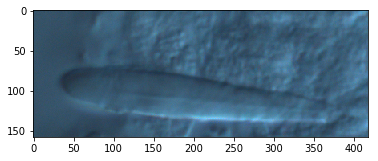

In [83]:
plt.imshow(cropped)

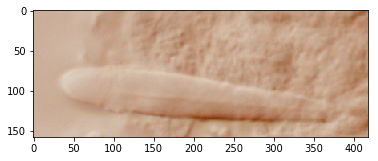

In [82]:
plt.imshow(rotate(cropped, 0, preserve_range=True))

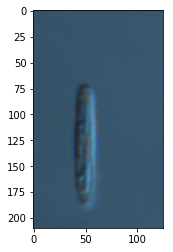

In [92]:
plt.imshow(cropped)

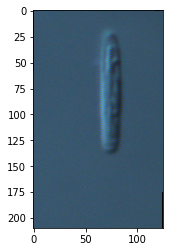

In [94]:
from scipy.ndimage.interpolation import rotate as rot2

plt.imshow(rot2(cropped, 180))

In [87]:
rotate(cropped, 0, preserve_range=True).astype('uint8')

array([[[ 49,  79, 103],
        [ 52,  81, 104],
        [ 53,  83, 103],
        ..., 
        [ 89, 149, 188],
        [ 97, 137, 171],
        [ 84, 132, 173]],

       [[ 56,  81,  98],
        [ 52,  81, 106],
        [ 53,  81, 105],
        ..., 
        [ 86, 148, 187],
        [ 81, 139, 176],
        [ 76, 131, 173]],

       [[ 52,  83,  98],
        [ 56,  83,  97],
        [ 50,  83, 101],
        ..., 
        [ 76, 148, 183],
        [ 90, 135, 166],
        [ 77, 132, 167]],

       ..., 
       [[ 50,  79,  97],
        [ 44,  76,  99],
        [ 51,  76,  94],
        ..., 
        [ 58,  95, 131],
        [ 59, 100, 123],
        [ 56, 101, 125]],

       [[ 49,  76,  93],
        [ 53,  73,  99],
        [ 51,  75,  93],
        ..., 
        [ 50,  96, 122],
        [ 58,  95, 124],
        [ 59,  99, 128]],

       [[ 45,  80,  94],
        [ 52,  73,  95],
        [ 50,  75,  97],
        ..., 
        [ 57,  95, 121],
        [ 57,  94, 135],
        [ 63, 100,

In [57]:
str(p).replace('\\', '_').replace('/', '_')

'samples_AnthopleuraPAN49@_filament_image0005.tif'

In [13]:
y_extent

(241, 343)

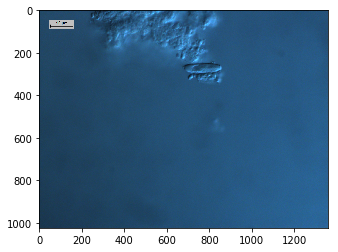

In [14]:
plt.imshow(im)

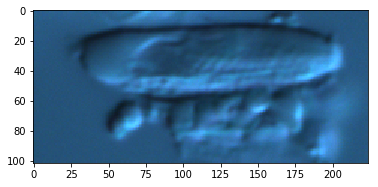

In [20]:
plt.imshow(cropped)

In [38]:
gray = rgb2gray(cropped)

hog(gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)).shape

c:\Users\Jeremy\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1024,)

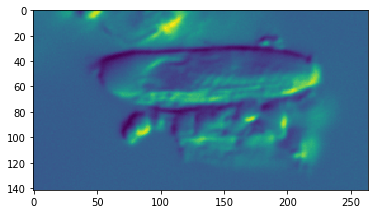

In [28]:

plt.imshow(rgb2gray(cropped))

In [35]:
16*16

256

In [46]:
cropped.shape

(270, 137, 3)

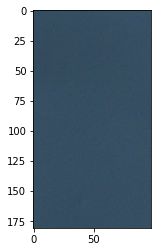

In [66]:
import random

w = random.randint(50,300)
l = random.randint(50,300)

x = random.randint(0, im.shape[1] - w)
y = random.randint(0, im.shape[0] - l)

plt.imshow(im[y:y+l,x:x+w])

In [65]:
im.shape

(1024, 1360, 3)

In [68]:
random.randint(0,100000000)

33036557

In [72]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

get_iou(
    {'x1': 1, 'x2': 4, 'y1': 0, 'y2': 4},
    {'x1': 1, 'x2': 4, 'y1': 5, 'y2': 9}
)

0.0